# 1. Environment Setup

In [1]:
# Standard library imports
import os
import random
import struct
from array import array
from os.path import join
from typing import NamedTuple, Optional, Tuple

In [2]:
# Third party imports
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from rotation import rotate_resize_and_cast, rotate_image

# 2. Download MNIST Dataset

In [4]:
# Download latest version of MNIST dataset
# path = kagglehub.dataset_download("hojjatk/mnist-dataset")

# print("Path to dataset files:", path)

# 3. Load MNIST Dataset

Training set: 60000 images, each 28x28 pixels
Testing set: 10000 images, each 28x28 pixels


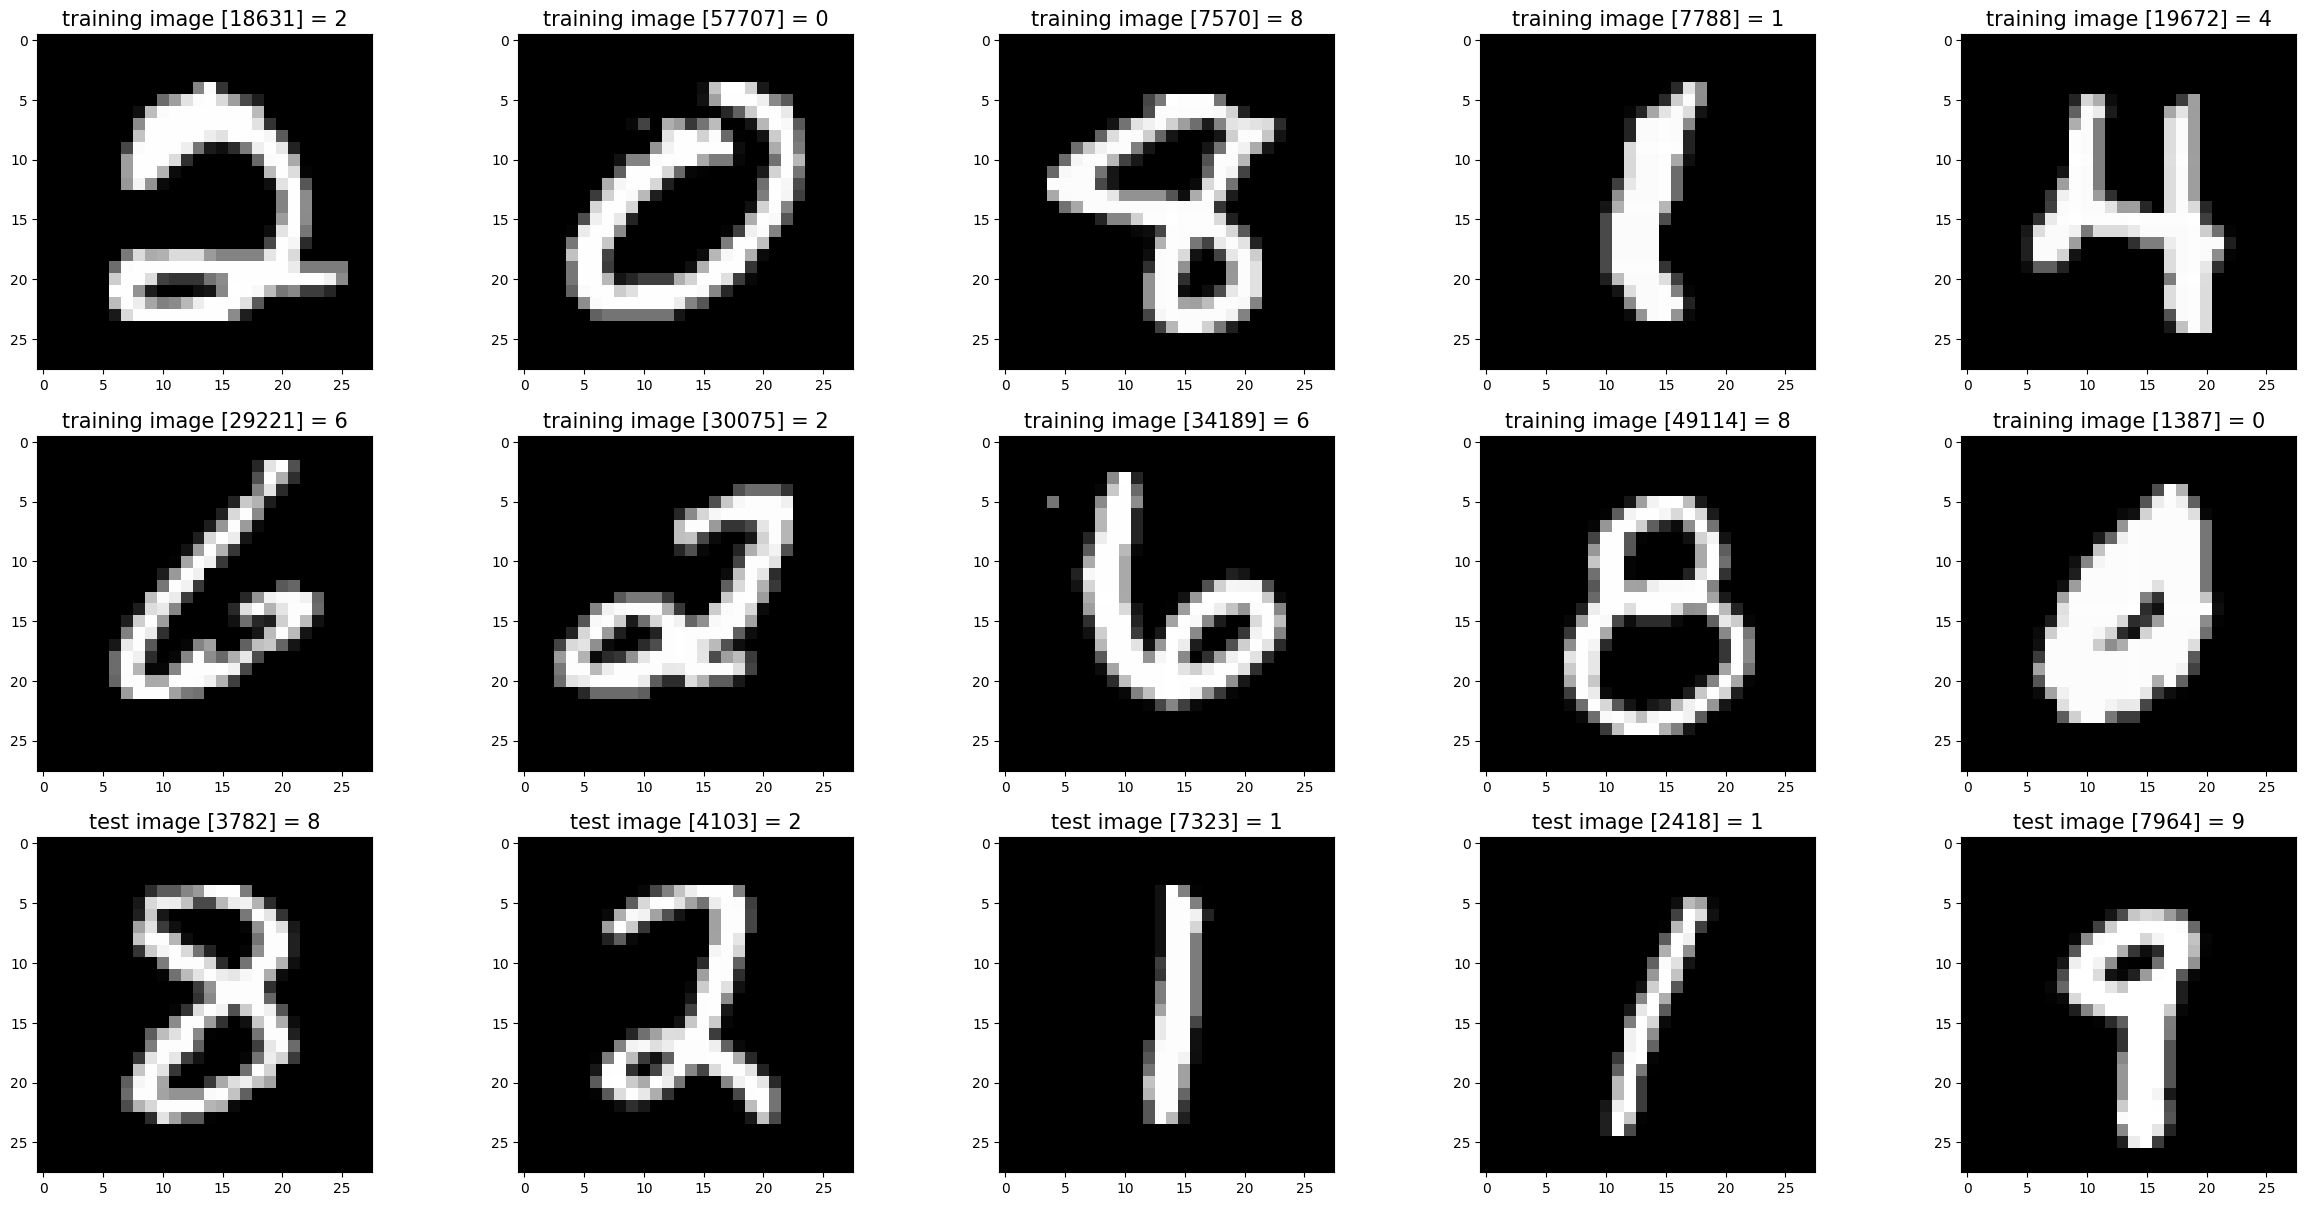

In [5]:
# If downloaded in above cell, make sure to adjust to use cached dir
path = "datasets/data/mnist_data/MNIST/raw"

# Update file paths directly in the main directory
train_image_file = os.path.join(path, 'train-images-idx3-ubyte')
train_label_file = os.path.join(path, 'train-labels-idx1-ubyte')
test_image_file = os.path.join(path, 't10k-images-idx3-ubyte')
test_label_file = os.path.join(path, 't10k-labels-idx1-ubyte')

""" MNIST Data Loader Class """
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)

# Load MINST dataset using the paths generated by Kagglehub
mnist_dataloader = MnistDataloader(train_image_file, train_label_file, test_image_file, test_label_file)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for img, title_text in zip(images, title_texts):
        plt.subplot(rows, cols, index)
        plt.imshow(img, cmap=plt.cm.gray)
        if title_text != '':
            plt.title(title_text, fontsize=15)
        index += 1

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

# Display dataset statistics
print(f"Training set: {len(x_train)} images, each 28x28 pixels")
print(f"Testing set: {len(x_test)} images, each 28x28 pixels")

# 4. Rotate Image Utility

Rotating along the X-axis...


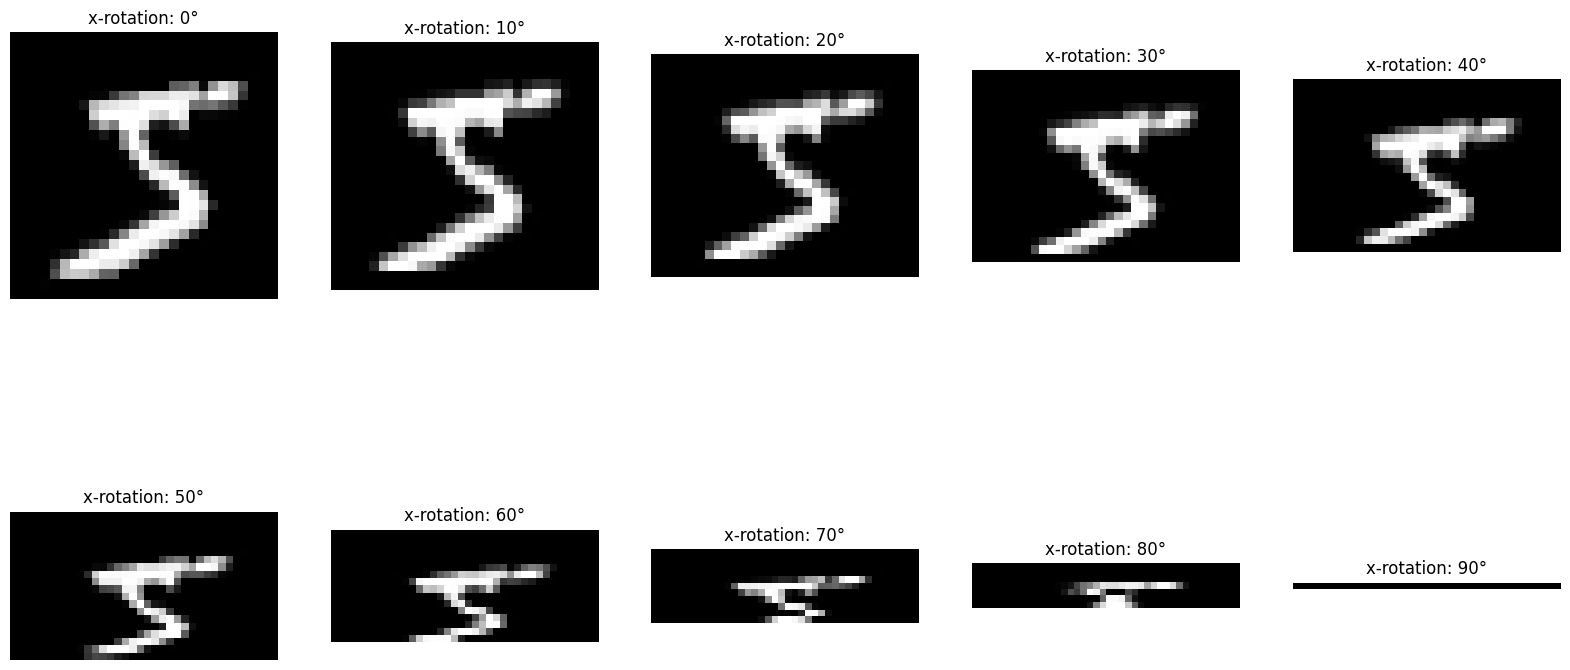

Rotating along the Y-axis...


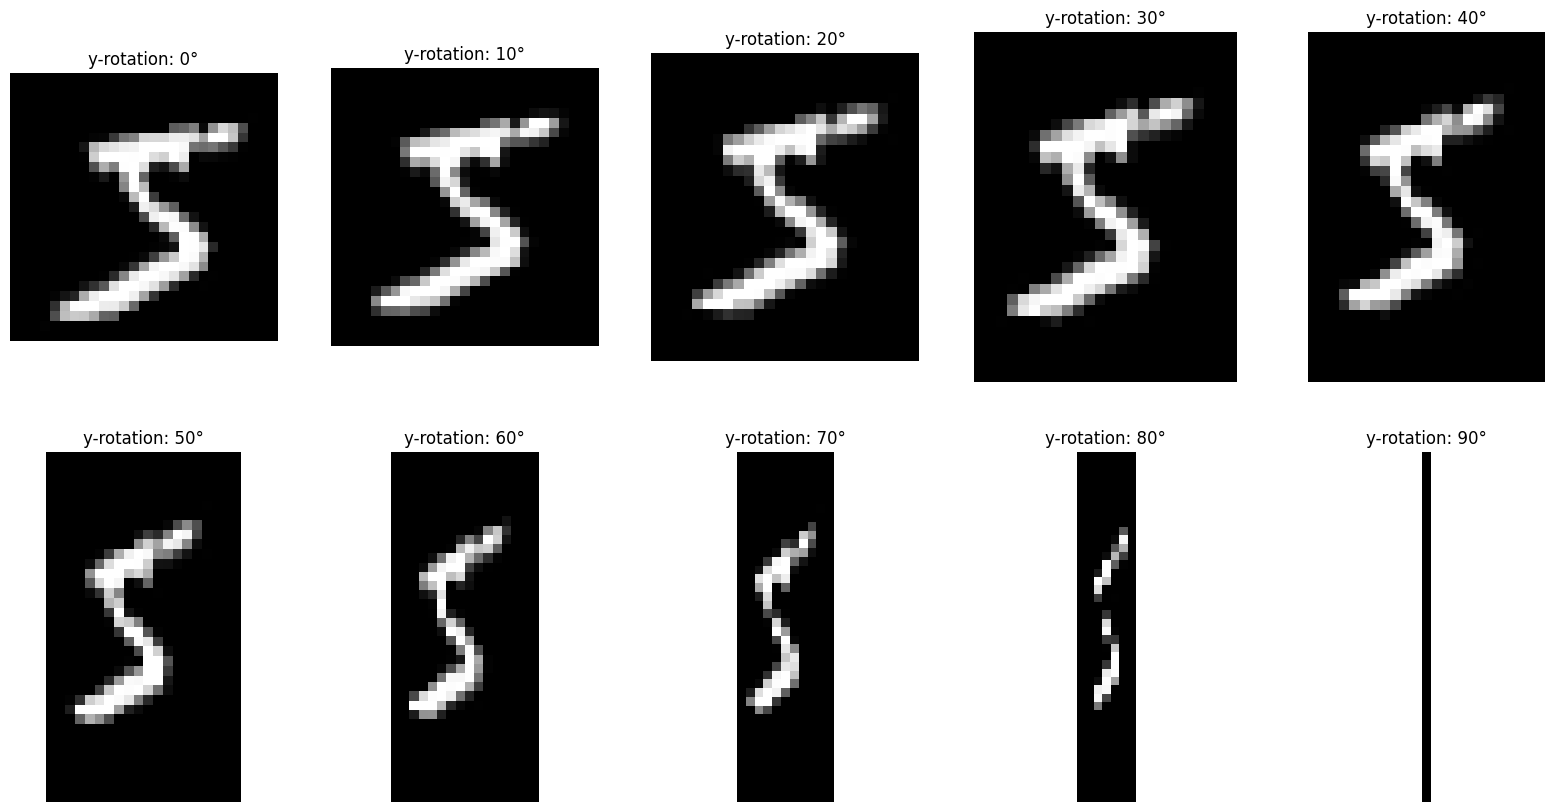

Rotating along the Z-axis...


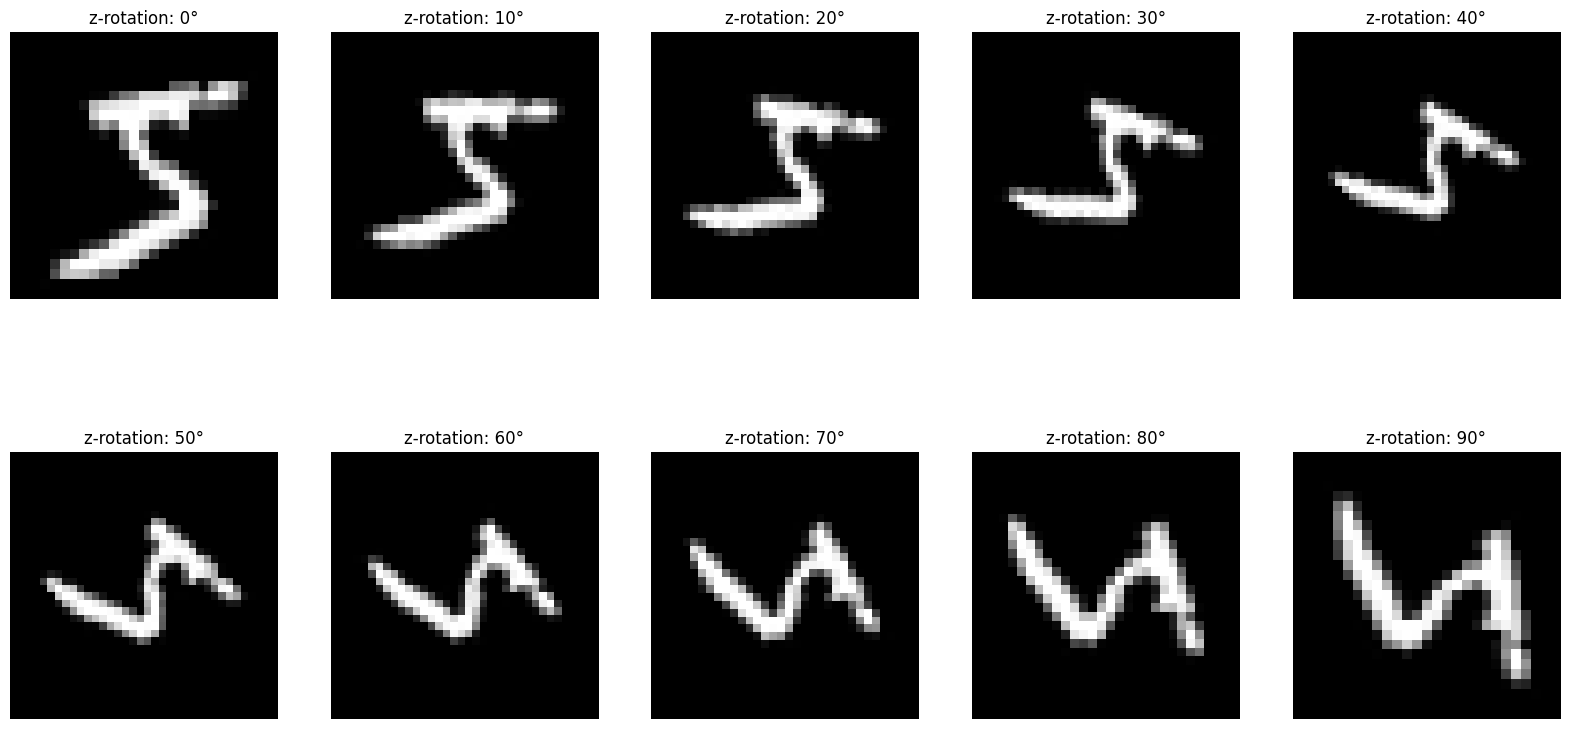

In [6]:
def rotate_and_display_sequence(image, axis='x'):
    """Displays a sequence of rotations on the specified axis from 0 to 90 degrees."""
    plt.figure(figsize=(20, 10))
    for i, angle in enumerate(range(0, 91, 10)):
        if axis == 'x':
            rotated_img = rotate_image(image, x_rotation=angle, y_rotation=0, z_rotation=0)
        elif axis == 'y':
            rotated_img = rotate_image(image, x_rotation=0, y_rotation=angle, z_rotation=0)
        elif axis == 'z':
            rotated_img = rotate_image(image, x_rotation=0, y_rotation=0, z_rotation=angle)

        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns grid for 10 images
        plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{axis}-rotation: {angle}°")
        plt.axis('off')
    plt.show()

# Use the first training image and convert it to BGR for display
img = np.array(x_train[0], dtype=np.uint8)
img_bgr = cv2.merge([img] * 3)

# Display rotations along each axis
print("Rotating along the X-axis...")
rotate_and_display_sequence(img_bgr, axis='x')

print("Rotating along the Y-axis...")
rotate_and_display_sequence(img_bgr, axis='y')

print("Rotating along the Z-axis...")
rotate_and_display_sequence(img_bgr, axis='z')

Rotating and casting along the X-axis...


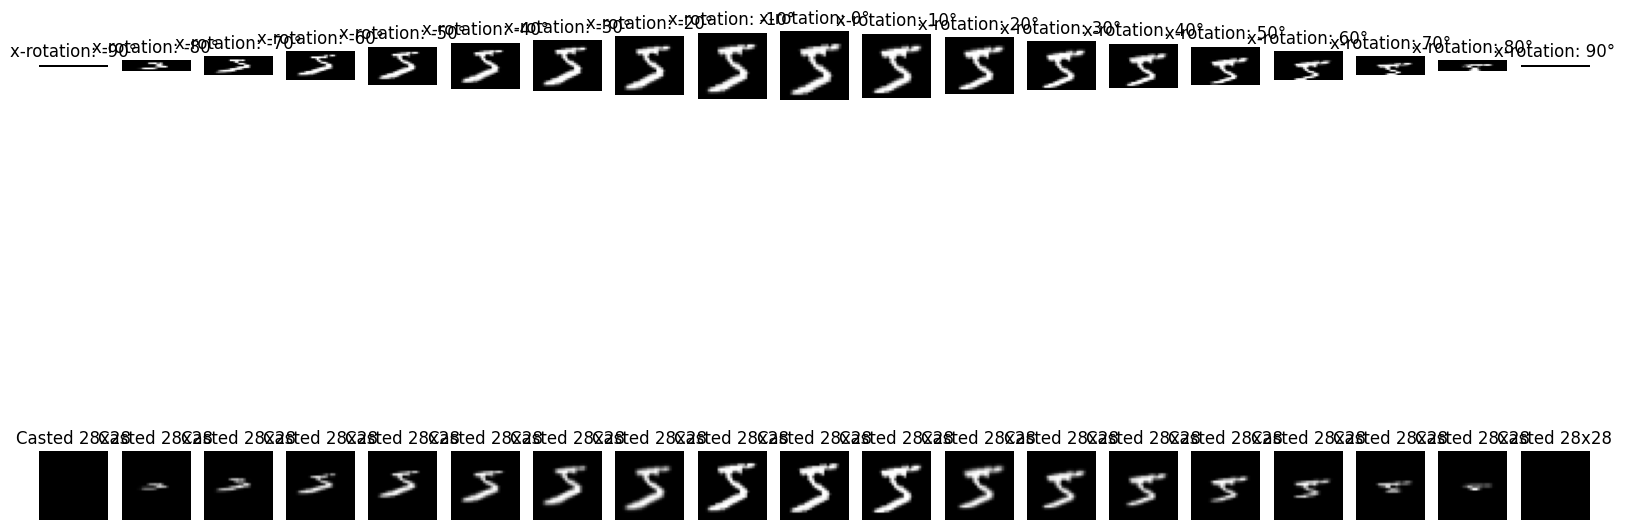

Rotating and casting along the Y-axis...


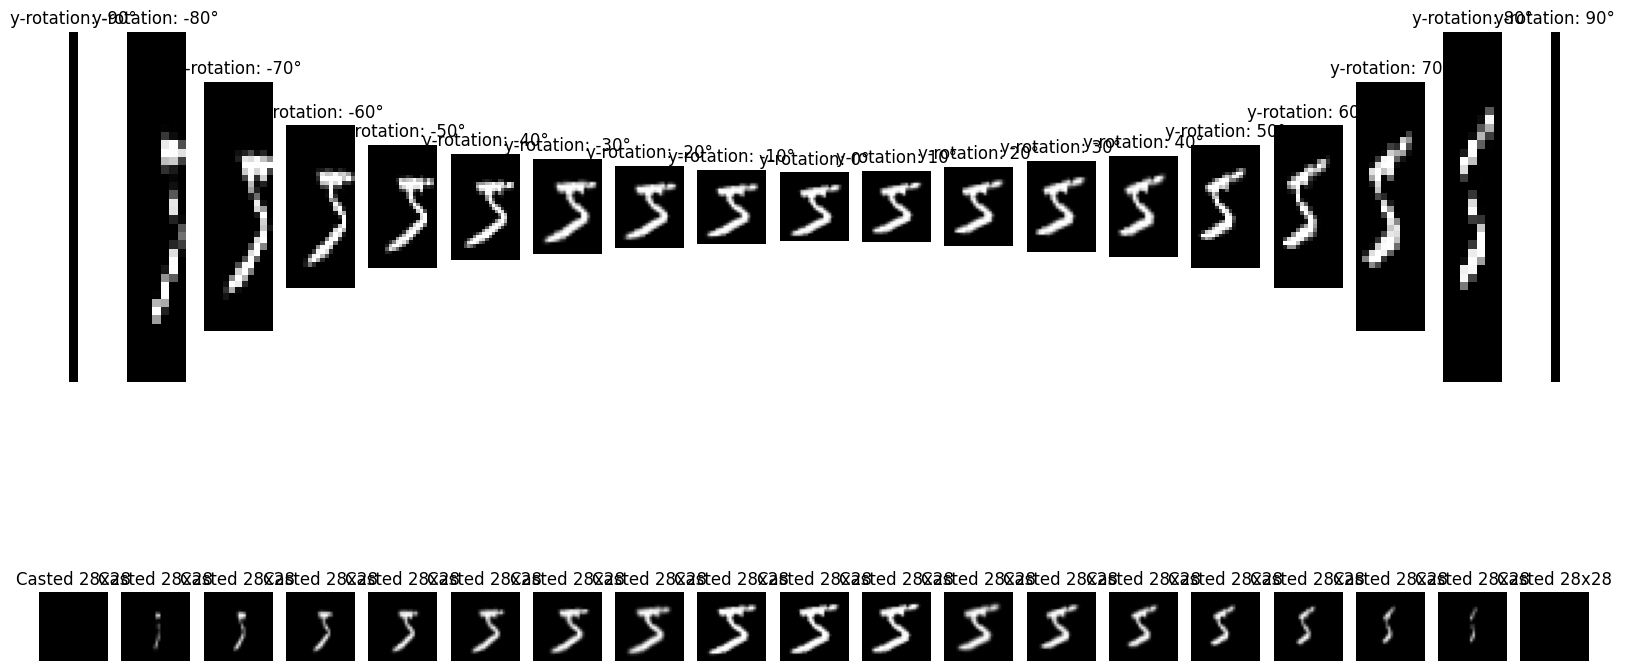

Rotating and casting along the Z-axis...


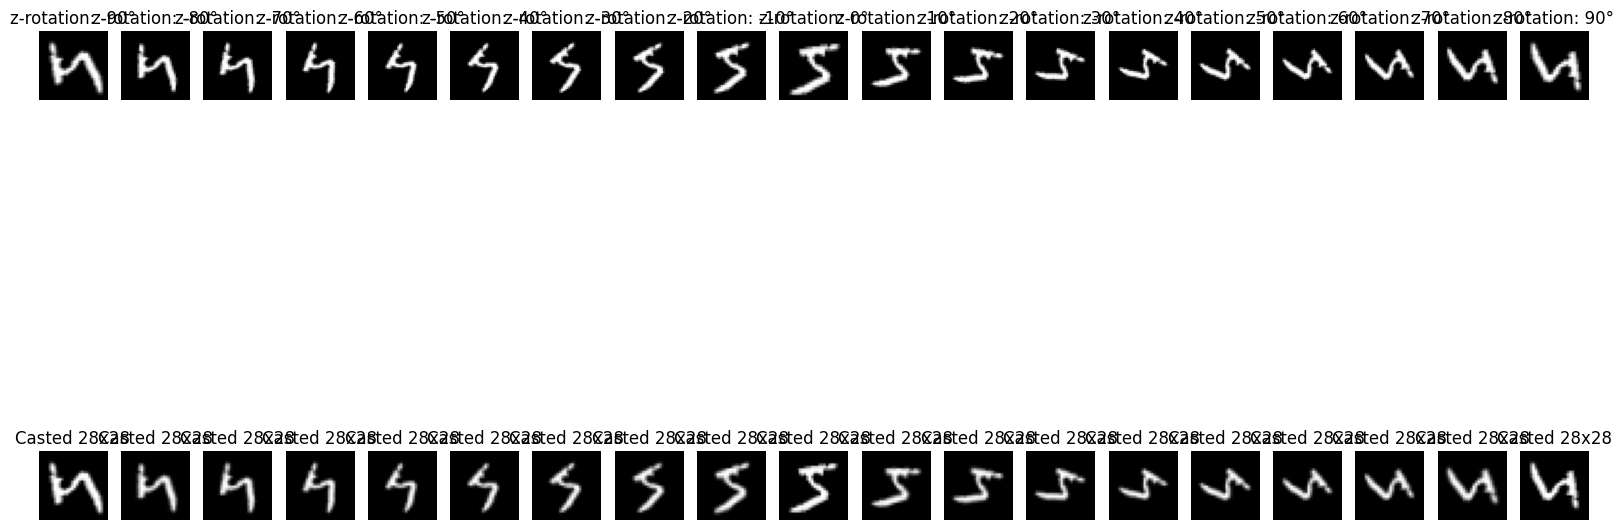

In [7]:
def display_rotations(image, axis='x'):
    """Displays rotations from -90 to 90 degrees along a specified axis with casting to 28x28."""
    plt.figure(figsize=(20, 10))
    angles = range(-90, 91, 10)
    for i, angle in enumerate(angles):
        # Rotate, resize, and cast
        if axis == 'x':
            rotated_img, canvas = rotate_resize_and_cast(image, x_rotation=angle)
        elif axis == 'y':
            rotated_img, canvas = rotate_resize_and_cast(image, y_rotation=angle)
        elif axis == 'z':
            rotated_img, canvas = rotate_resize_and_cast(image, z_rotation=angle)

        # Display the original rotated image
        plt.subplot(2, len(angles), i + 1)
        plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{axis}-rotation: {angle}°")
        plt.axis('off')

        # Display the casted image on the 28x28 canvas
        plt.subplot(2, len(angles), i + 1 + len(angles))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.title("Casted 28x28")
        plt.axis('off')
    plt.show()

# Use the first training image and convert it to BGR for display
img = np.array(x_train[0], dtype=np.uint8)
img_bgr = cv2.merge([img] * 3)

# Display rotations with casted 28x28 images
print("Rotating and casting along the X-axis...")
display_rotations(img_bgr, axis='x')

print("Rotating and casting along the Y-axis...")
display_rotations(img_bgr, axis='y')

print("Rotating and casting along the Z-axis...")
display_rotations(img_bgr, axis='z')


Minor Rotations (-15° to 15°)
--------------------------------------------------

X-Axis Rotations

Y-Axis Rotations

Z-Axis Rotations


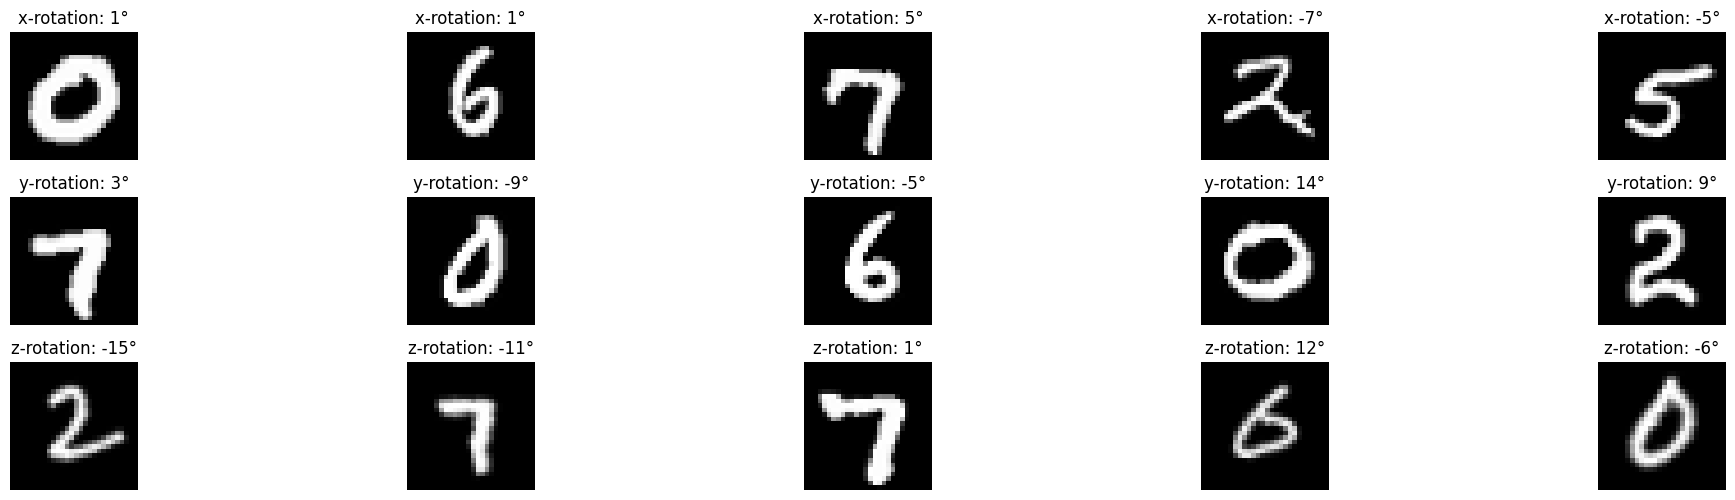


Moderate Rotations (-45° to 45°)
--------------------------------------------------

X-Axis Rotations

Y-Axis Rotations

Z-Axis Rotations


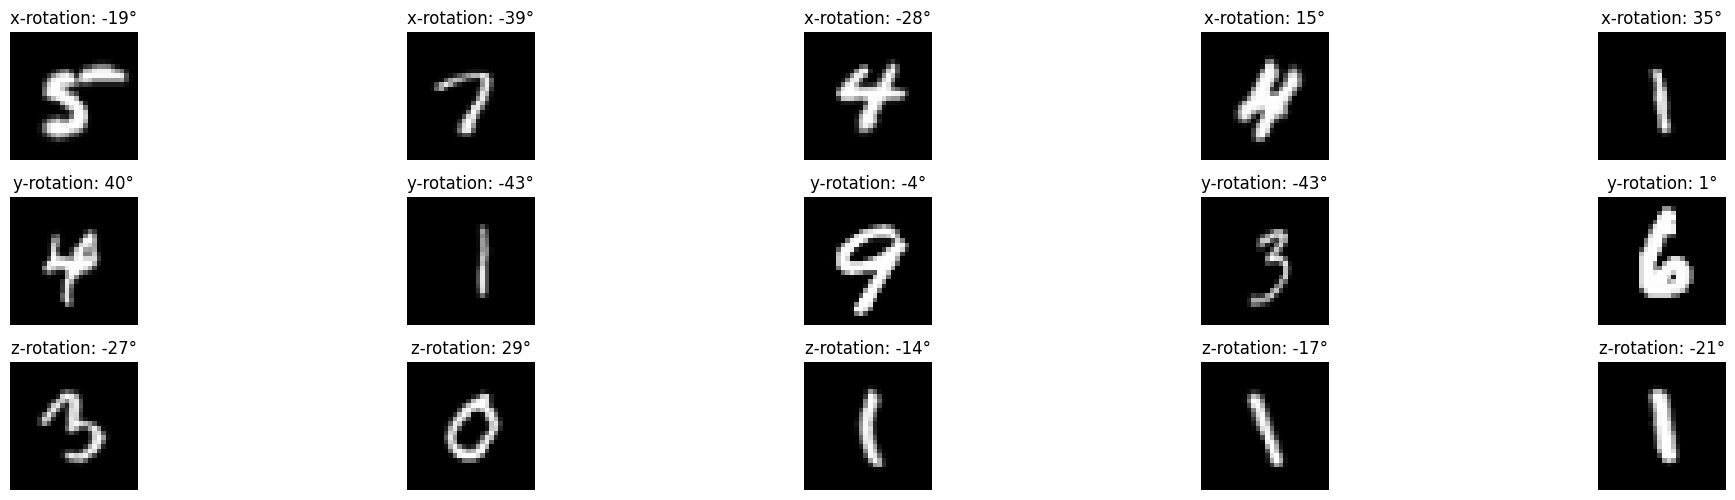


Extreme Rotations (-90° to 90°)
--------------------------------------------------

X-Axis Rotations

Y-Axis Rotations

Z-Axis Rotations


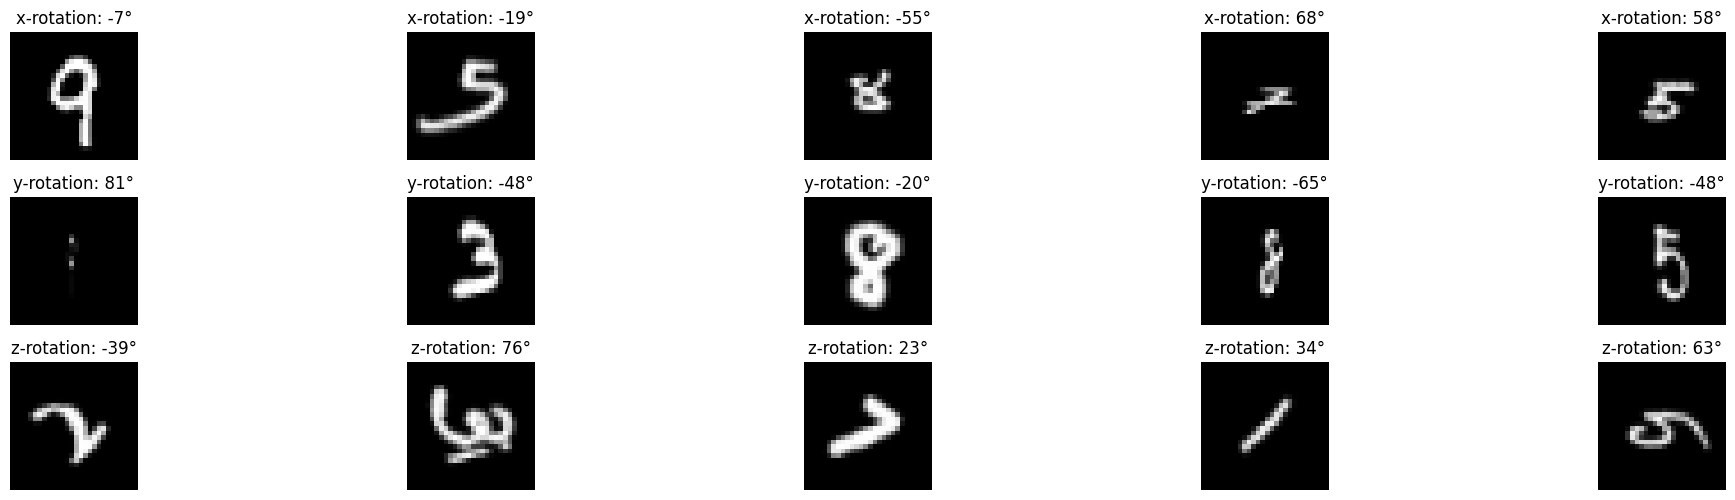

In [8]:
def display_category_rotations(x_test, severity_ranges):
    """
    Display rotated images for different severity categories and axes
    severity_ranges: dict with category names and their angle ranges
    """
    for category, angle_range in severity_ranges.items():
        print(f"\n{category} Rotations ({angle_range[0]}° to {angle_range[1]}°)")
        print("-" * 50)
        
        plt.figure(figsize=(20, 15))
        current_plot = 1
        
        for axis in ['x', 'y', 'z']:
            print(f"\n{axis.upper()}-Axis Rotations")
            
            for i in range(5):
                # Randomly select an image and angle
                idx = np.random.randint(0, len(x_test))
                img = np.array(x_test[idx], dtype=np.uint8)
                img_bgr = cv2.merge([img] * 3)
                
                angle = np.random.randint(angle_range[0], angle_range[1])
                
                # Rotate image based on axis
                if axis == 'x':
                    rotated_img, canvas = rotate_resize_and_cast(img_bgr, x_rotation=angle)
                elif axis == 'y':
                    rotated_img, canvas = rotate_resize_and_cast(img_bgr, y_rotation=angle)
                else:  # z-axis
                    rotated_img, canvas = rotate_resize_and_cast(img_bgr, z_rotation=angle)
                
                # Display rotated and casted images
                plt.subplot(9, 5, current_plot)
                plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
                plt.title(f"{axis}-rotation: {angle}°")
                plt.axis('off')
                
                current_plot += 1
            
        plt.tight_layout()
        plt.show()

# Define severity ranges
severity_ranges = {
    "Minor": (-15, 15),
    "Moderate": (-45, 45),
    "Extreme": (-90, 90)
}

# Display rotations for all categories
display_category_rotations(x_test, severity_ranges)

# 5. Upsampling

In [9]:
def upsample_image(image, new_size):
    """Upsamples an image to a new size using interpolation.
    
    Args:
        image: Input image array
        new_size: Tuple of (width, height) for target size
        
    Returns:
        Upsampled image array
    """
    return cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

In [10]:
def upsample_image_enhanced(image, new_size, method='multistep'):
    """Upsamples an image to a new size using enhanced interpolation techniques.
    
    Args:
        image: Input image array
        new_size: Tuple of (width, height) for target size
        method: 'bicubic' or 'multistep' for different upsampling approaches
        
    Returns:
        Upsampled image array with enhanced detail
    """
    if method == 'bicubic':
        # Enhanced bicubic interpolation
        return cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    
    elif method == 'multistep':
        # Multi-step upsampling with edge enhancement
        current_size = image.shape[:2]
        target_size = new_size[1], new_size[0]  # Convert to (height, width)
        
        # Calculate number of steps needed (e.g., 28->56->112->140)
        steps = []
        current = min(current_size)
        while current < max(target_size):
            current *= 2
            steps.append(min(current, max(target_size)))
        
        # Gradual upsampling with edge preservation
        current_img = image.copy()
        
        for target in steps:
            scale = target / current_img.shape[0]
            interim_size = (
                int(current_img.shape[1] * scale),
                int(current_img.shape[0] * scale)
            )
            
            # Apply slight sharpening before each upscale
            kernel = np.array([[-1,-1,-1],
                             [-1, 9,-1],
                             [-1,-1,-1]]) / 9
            current_img = cv2.filter2D(current_img, -1, kernel)
            
            # Upscale with cubic interpolation
            current_img = cv2.resize(current_img, interim_size, 
                                   interpolation=cv2.INTER_CUBIC)
            
        # Final resize to exact target size
        final_img = cv2.resize(current_img, new_size, 
                             interpolation=cv2.INTER_CUBIC)
        
        return final_img

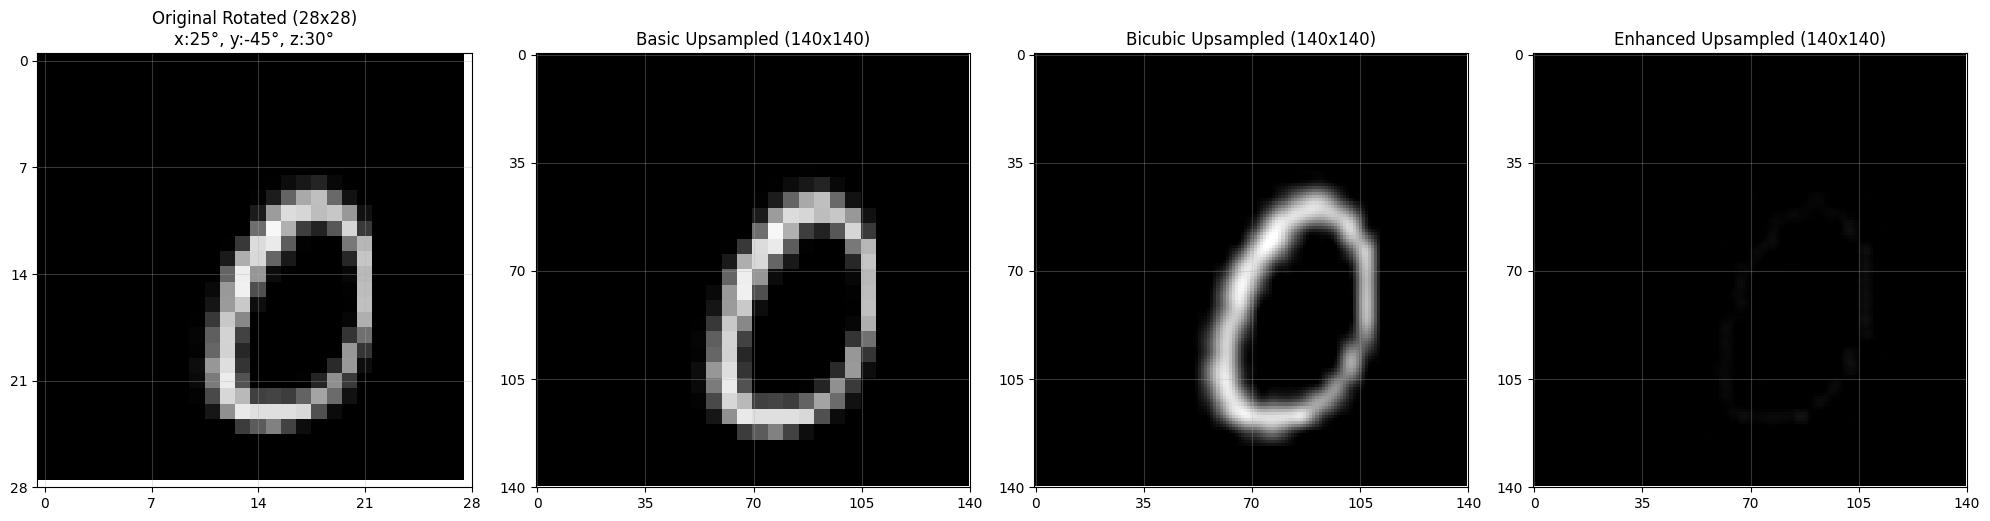

In [11]:
# Get and rotate a sample image
random_index = random.randint(0, len(x_train) - 1)
image = np.array(x_train[random_index], dtype=np.uint8)
image_bgr = cv2.merge([image] * 3)

# Rotate and cast the image
xr, yr, zr = 25, -45, 30
rotated_img, casted_img = rotate_resize_and_cast(image_bgr, x_rotation=xr, y_rotation=yr, z_rotation=zr)

# Create different upsampled versions
basic_upsampled = cv2.resize(casted_img, (140, 140), interpolation=cv2.INTER_NEAREST)
bicubic_upsampled = upsample_image_enhanced(casted_img, (140, 140), method='bicubic')
enhanced_upsampled = upsample_image_enhanced(casted_img, (140, 140), method='multistep')

# Display all versions
plt.figure(figsize=(20, 5))

# Original casted image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(casted_img, cv2.COLOR_BGR2RGB))
plt.title(f'Original Rotated (28x28)\nx:{xr}°, y:{yr}°, z:{zr}°')
plt.xticks(np.arange(0, 29, 7))
plt.yticks(np.arange(0, 29, 7))
plt.grid(True, alpha=0.3)

# Basic nearest-neighbor upsampling
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(basic_upsampled, cv2.COLOR_BGR2RGB))
plt.title('Basic Upsampled (140x140)')
plt.xticks(np.arange(0, 141, 35))
plt.yticks(np.arange(0, 141, 35))
plt.grid(True, alpha=0.3)

# Bicubic upsampling
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(bicubic_upsampled, cv2.COLOR_BGR2RGB))
plt.title('Bicubic Upsampled (140x140)')
plt.xticks(np.arange(0, 141, 35))
plt.yticks(np.arange(0, 141, 35))
plt.grid(True, alpha=0.3)

# Enhanced multi-step upsampling
plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(enhanced_upsampled, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Upsampled (140x140)')
plt.xticks(np.arange(0, 141, 35))
plt.yticks(np.arange(0, 141, 35))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()